In [1]:
# Load the Julia environment needed for this notebook
import Pkg
Pkg.activate("../Tasks2D")


  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
import LinearAlgebra
import Makie   # Visualization Library
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session
using Gen         # Gen probabilistic programming library
import GenParticleFilters # Additional particle filtering functionality for Gen
import GridWorlds # Simple gridworld functionality
import LineWorlds
const L = LineWorlds
import LineWorlds: cast # Ray caster
import GenPOMDPs  # Beginnings of a Gen POMDP library

import Tasks2D

includet("SLAM/Utils.jl")

In [32]:
import CairoMakie
CairoMakie.activate!()

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
┌ Warning: Module Makie with build ID fafbfcfd-0759-6f1b-0007-7ad0be47bc99 is missing from the cache.
│ This may mean Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
[ Info: Skipping precompilation since __precompile__(false). Importing CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0].
[ Info: Precompiling Cairo [159f3aea-2a34-519c-b102-8c37f9878175]
┌ Warning: Module Cairo_jll with build ID fafbfcfd-d9b0-506d-0007-7ad6e7964399 is missing from the cache.
│ This may mean Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793
[ Info: Skipping precompilation since __precompile__(false). Importing Cairo [159f3aea-2a34-519c-b102-8c37f9878175].
[ Info: Precompiling Pango_jll [36c8627f-9965-5494-a995-c6b170f724f3]
┌ Warning: Module Cairo_jll 

In [33]:
# Initial position model

# Distribution to sample uniformly from a Julia Set
using Tasks2D.Distributions: uniform_from_set

@gen (static) function uniform_agent_pos(t_to_params)
    w = t_to_params(0).map # a map, represented as a GridWorlds.GridWorld
    
    cell ~ uniform_from_set(GridWorlds.empty_cells(w))
    
    # Cell (i, j) corresponds to the region from i-1 to i and j-1 to j
    x ~ uniform(cell[1] - 1, cell[1])
    y ~ uniform(cell[2] - 1, cell[2])
    
    return ([x, y], 0, false)
end

function det_next_pos(pos, a, Δ)
    (x, y) = pos
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

function handle_wall_intersection(prev, new, gridworld)
    walls = GridWorlds.nonempty_segments(gridworld)
    move = L.Segment(prev, new)
    
    min_collision_dist = Inf
    vec_to_min_dist_collision = nothing
    for i in 1:(size(walls)[1])
        wall = walls[i, :]
        # print("wall: $wall")
        do_intersect, dist = L.Geometry.cast(move, L.Segment(wall))

        if do_intersect && dist ≤ L.Geometry.norm(move)
            if dist < min_collision_dist
                min_collision_dist = dist
                vec_to_min_dist_collision = L.Geometry.diff(move)
            end
        end
    end
    
    if !isnothing(vec_to_min_dist_collision)
        dist = min_collision_dist
        if dist < 0.05
            return (prev, true)
        else
            normalized_vec = (vec_to_min_dist_collision / L.Geometry.norm(vec_to_min_dist_collision))
            collision_pt = prev + (dist - 0.04) * normalized_vec
            return (collision_pt, true)
        end
    end
    
    return (new, false)
end

@gen (static) function motion_model(state, action, t_to_params)
    (a, wall_clock_time) = action
    (pos, t_prev, prev_hit_wall) = state
    params = t_to_params(t_prev + 1)
    w, σ = params.map, params.step.σ
    
    next_pos_det = det_next_pos(pos, a, params.step.Δ)
    noisy_next_pos ~ broadcasted_normal(next_pos_det, params.step.σ)
    (next_pos, hit_wall) = handle_wall_intersection(pos, noisy_next_pos, w)
    
    return (next_pos, t_prev + 1, prev_hit_wall || hit_wall)
end

@gen function observe_noisy_distances(state, t_to_params)
    (pos, t, _) = state
    params = t_to_params(t)

    p = reshape([pos..., params.obs.orientation], (1, 3))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    wall_segs = GridWorlds.wall_segments(params.map)
    strange_segs = GridWorlds.strange_segments(params.map)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.wall_sensor_args
    dists_walls = L.cast(p, wall_segs; num_a=params.obs.n_rays, zmax)
    dists_walls = reshape(dists_walls, (:,))

    w, s_noise, outlier, outlier_vol, zmax = params.obs.strange_sensor_args
    dists_strange = L.cast(p, strange_segs; num_a=params.obs.n_rays, zmax)
    dists_strange = reshape(dists_strange, (:,))

    is_wall_measurement = [w < s for (w, s) in zip(dists_walls, dists_strange)]
    wall_measurements = dists_walls[is_wall_measurement]
    
    σ_wall = params.obs.wall_sensor_args.σ
    noisy_wall_measurements ~ Gen.broadcasted_normal(wall_measurements, s_noise)

    strange_measurements = dists_strange[[!w for w in is_wall_measurement]]
    if !isempty(strange_measurements)
        mins = [params.obs.strange_sensor_args.dist_to_zmin(m) for m in strange_measurements]
        maxs = [params.obs.strange_sensor_args.dist_to_zmax(m) for m in strange_measurements]
        noisy_strange_measurements ~ Utils.mapped_uniform(mins, maxs)
    else
        noisy_strange_measurements = []
    end

    obs = []
    wall_ctr = 1
    strange_ctr = 1
    for i in 1:params.obs.n_rays
        if is_wall_measurement[i]
            push!(obs, noisy_wall_measurements[wall_ctr])
            wall_ctr += 1
        else
            push!(obs, noisy_strange_measurements[strange_ctr])
            strange_ctr += 1
        end
    end
    # dists = min.(dists_walls, dists_strange)
    # dists = reshape(dists, (:,))

    # # get vector of sigmas, to apply to `dists`
    # # params.obs.sensor_args.σ_wall for walls; params.obs.sensor_args.σ_strange for strange
    # # σ_strange = params.obs.strange_sensor_args.σ
    # sigmas = [w < s ? σ_wall : σ_strange for (w, s) in zip(dists_walls, dists_strange)]
    # sigmas = reshape(sigmas, (:,))

    # obs ~ Gen.mvnormal(dists, LinearAlgebra.Diagonal(sigmas))
    return obs
end

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisy_distances, # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#703"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [34]:
function get_posobs_seq(groundtruth_trace)
    return map(
        trace -> (
            [p for (p, t, h) in GenPOMDPs.state_sequence(trace)],
            [reshape(o, (:,)) for o in GenPOMDPs.observation_retval_sequence(trace)]
        ),
        groundtruth_trace
    )
end
function get_obs_seq(groundtruth_trace)
    return map(
        trace -> [reshape(o, (:,)) for o in GenPOMDPs.observation_retval_sequence(trace)],
        groundtruth_trace
    )
end

using Dates

function get_save_tr(tr)
    function save_tr(viz_actions)
        filename = "saves/" * string(now()) * "__pomdp_trace.jld"
        Utils.serialize_trace_and_viz_actions(filename, tr[];
            viz_actions=viz_actions,
            # args_to_serializeable = args -> (args[1:2]..., args[3].params)
        )
    end
    return save_tr
end

function get_take_action(_take_action)
    function take_action(a)
        _take_action((a, Dates.now()))
    end
    return take_action
end
function get_interactive_trace(args...; kwargs...)
    (trace, _take_action) = GenPOMDPs.interactive_world_trace(args...; kwargs...)
    return (trace, get_take_action(_take_action))
end
function make_trace_interactive(args...; kwargs...)
    (trace, _take_action) = GenPOMDPs.make_trace_interactive(args...; kwargs...)
    return (trace, get_take_action(_take_action))
end

function get_did_hitwall_observable(trace)
    return map(trace -> GenPOMDPs.state_sequence(trace)[end][3], trace)
end
function close_window(f)
    glfw_window = GLMakie.to_native(display(f))
    GLMakie.GLFW.SetWindowShouldClose(glfw_window, true)
end

function get_action_times_observable(trace)
    return map(trace -> [t for (a, t) in GenPOMDPs.action_sequence(trace)], trace)
end
function get_timing_args(trace; speedup_factor=1, max_delay=5) # 5 seconds max delay
    return (get_action_times_observable(trace), speedup_factor, max_delay)
end

struct ConstantTToParams
    params
end
(p::ConstantTToParams)(t) = p.params

struct SwitchTToParams
    params1
    params2
    switch
end
(p::SwitchTToParams)(t::Makie.Observable) = p(t[])
(p::SwitchTToParams)(t) = p.switch(t) ? p.params1 : p.params2

struct TimedSwitchTToParams
    params1
    params2
    timewindows_params1
    timewindows_params2
end
(p::TimedSwitchTToParams)(t::Makie.Observable) = p(t[])
function (p::TimedSwitchTToParams)(t)
    for (start, stop) in p.timewindows_params1
        if start ≤ t ≤ stop
            return p.params1
        end
    end
    for (start, stop) in p.timewindows_params2
        if start ≤ t ≤ stop
            return p.params2
        end
    end
    error("No time window found for time $t")
end

struct DistanceToConstant
    c
end
(d::DistanceToConstant)(x) = d.c
struct MultiplyDistanceByConstant
    c
end
(d::MultiplyDistanceByConstant)(x) = 2. + x * d.c

In [35]:
readdir("saves")

459-element Vector{String}:
 "2023-12-06T15:21:41.953__pomdp_trace.jld"
 "2023-12-12T14:01:29.780__pomdp_trace.jld"
 "2023-12-12T14:01:39.916__pomdp_trace.jld"
 "2023-12-12T14:04:01.037__pomdp_trace.jld"
 "2023-12-12T14:07:17.605__pomdp_trace.jld"
 "2023-12-12T14:17:17.424__pomdp_trace.jld"
 "2023-12-12T14:32:17.755__pomdp_trace.jld"
 "2023-12-12T14:36:09.460__pomdp_trace.jld"
 "2023-12-12T15:27:52.313__pomdp_trace.jld"
 "2023-12-12T15:50:16.517__pomdp_trace.jld"
 "2023-12-12T15:51:18.757__pomdp_trace.jld"
 "2023-12-12T16:03:19.086__pomdp_trace.jld"
 "2023-12-12T16:10:20.411__pomdp_trace.jld"
 ⋮
 "2023-12-16T17:19:36.234__pomdp_trace.jld"
 "2023-12-16T17:19:38.071__pomdp_trace.jld"
 "2023-12-16T17:19:43.617__pomdp_trace.jld"
 "2023-12-16T17:21:09.530__pomdp_trace.jld"
 "2023-12-17T12:06:03.464__pomdp_trace.jld"
 "2023-12-17T12:08:36.904__pomdp_trace.jld"
 "2023-12-17T13:31:39.676__pomdp_trace.jld"
 "2023-12-17T13:36:27.406__pomdp_trace.jld"
 "2023-12-17T13:36:42.443__pomdp_trace.jld"
 

In [266]:
# Unique identifier substring of the first save for each participant.
firsts = sort([
    "13T18:04:45", # lio
    "13T18:37:32", # mirko
    # "14T10:44:03", # Me playing around.  TODO - delete 14T10:44:03 to 14T10:52:44
    "14T11:58", # matin
    "14T12:16", # adam
    "14T12:52", # nick
    "14T13:07", # eddie
    "14T13:19", # julia
    "14T16:02", # eric
    "14T16:38", # marc
    "14T16:52", # ryan
    "14T17:01", # isha
    "14T19:49", # vikash    
    "16T14:38" # aneesh
])

13-element Vector{String}:
 "13T18:04:45"
 "13T18:37:32"
 "14T11:58"
 "14T12:16"
 "14T12:52"
 "14T13:07"
 "14T13:19"
 "14T16:02"
 "14T16:38"
 "14T16:52"
 "14T17:01"
 "14T19:49"
 "16T14:38"

In [275]:
participant_names = ["lio", "mirko", "matin", "adam", "nick", "eddie", "julia", "eric", "marc", "ryan", "isha", "vikash", "aneesh"]

13-element Vector{String}:
 "lio"
 "mirko"
 "matin"
 "adam"
 "nick"
 "eddie"
 "julia"
 "eric"
 "marc"
 "ryan"
 "isha"
 "vikash"
 "aneesh"

In [267]:
file_sets = []
participant_idx = 0
for filename in readdir("saves")
    !contains(filename, "pomdp_trace.jld") && continue
    if participant_idx < length(firsts) && contains(filename, firsts[participant_idx + 1])
        push!(file_sets, [filename])
        participant_idx += 1
    elseif participant_idx > 0
        push!(file_sets[end], filename)
    end
end

In [268]:
file_sets

13-element Vector{Any}:
 ["2023-12-13T18:04:45.219__pomdp_trace.jld", "2023-12-13T18:14:18.649__pomdp_trace.jld", "2023-12-13T18:16:54.539__pomdp_trace.jld", "2023-12-13T18:16:54.570__pomdp_trace.jld", "2023-12-13T18:17:32.599__pomdp_trace.jld", "2023-12-13T18:19:45.183__pomdp_trace.jld", "2023-12-13T18:21:51.756__pomdp_trace.jld", "2023-12-13T18:21:52.908__pomdp_trace.jld", "2023-12-13T18:21:53.015__pomdp_trace.jld"]
 ["2023-12-13T18:37:32.078__pomdp_trace.jld", "2023-12-13T18:37:32.094__pomdp_trace.jld", "2023-12-13T18:37:32.130__pomdp_trace.jld", "2023-12-13T18:37:32.166__pomdp_trace.jld", "2023-12-13T18:37:32.205__pomdp_trace.jld", "2023-12-13T18:37:32.250__pomdp_trace.jld", "2023-12-13T18:37:32.286__pomdp_trace.jld", "2023-12-13T18:40:08.657__pomdp_trace.jld", "2023-12-13T18:40:47.556__pomdp_trace.jld", "2023-12-13T18:42:02.441__pomdp_trace.jld", "2023-12-13T18:42:37.832__pomdp_trace.jld"]
 ["2023-12-14T11:58:19.831__pomdp_trace.jld", "2023-12-14T11:58:24.638__pomdp_trace.jld", "2

In [295]:
function deduplicate_participant_traces(traces)
    isempty(traces) && return traces
    i = 1
    while get_args(traces[i])[1] < 3
        i += 1
        if i > length(traces)
            return []
        end
    end
    deduplicated = [traces[i]]
    for tr in traces[i+1:end]
        prev_tr = deduplicated[end]

        actions1 = GenPOMDPs.action_sequence(prev_tr)
        actions2 = GenPOMDPs.action_sequence(tr)
        is_prefix = true
        for (a1, a2) in zip(actions1, actions2)
            if a1 != a2
                is_prefix = false
                break
            end
        end
        if !is_prefix
            push!(deduplicated, tr)
        end
    end
    return deduplicated
end

deduplicate_participant_traces (generic function with 1 method)

In [296]:
function load_tr(filename)
    tr, _ = Utils.deserialize_trace_and_viz_actions(
        filename,
        trajectory_model,
    );
    return tr
end
load_file_and_visualize(filename) = visualize_trace(load_tr(filename))
function visualize_trace(tr)
    trace, take_action = make_trace_interactive(tr);

    (f, t, _replay_actions) = GridWorlds.Viz.interactive_gui(
        t -> get_args(trace[])[3](t).map, get_posobs_seq(trace), take_action,
        save_fn=get_save_tr(trace),
        framerate=8,

        # Timing control for playback
        timing_args=get_timing_args(trace; speedup_factor=6, max_delay=1)
    )
    display(f)
end

visualize_trace (generic function with 1 method)

In [297]:
traces = []
for fileset in file_sets
    traces_for_participant = []
    for filename in fileset
        push!(traces_for_participant, load_tr("saves/" * filename))
    end
    traces_for_participant = deduplicate_participant_traces(traces_for_participant)
    push!(traces, traces_for_participant)
    println("added traces for participant $(participant_names[length(traces)])")
end

added traces for participant lio
added traces for participant mirko
added traces for participant matin
added traces for participant adam
added traces for participant nick
added traces for participant eddie
added traces for participant julia
added traces for participant eric
added traces for participant marc
added traces for participant ryan
added traces for participant isha
added traces for participant vikash
added traces for participant aneesh


In [330]:
function trace_reached_cross(tr)
    return any(near_cross(pos[1], pos[2]) for (pos, _, _) in GenPOMDPs.state_sequence(tr))
end
function near_cross(x, y)
    return 26 <= x <= 35 && 2 <= y <= 8
end

function behind_wall_map1(x, y)
    return x <= 11 && y < 16
end
function behind_wall_map2(x, y)
    return x <= 17 && y < 16
end

function trace_hit_barrier(tr)
    return behind_wall_map2(GenPOMDPs.state_sequence(tr)[end][1]...)
end

trace_hit_barrier (generic function with 1 method)

## inspect

In [299]:
map(length, traces)

13-element Vector{Int64}:
  5
  5
  8
 13
  6
  7
  6
  6
  7
  6
 11
  7
 12

In [300]:
i = 0

0

In [301]:
length(traces[11])

11

In [302]:
MAP_INTRO = GridWorlds.load_houseexpo_gridworld(24, 1)
MAP_EXPLAIN_STRANGE = GridWorlds.load_custom_map(3)
MAP_W_STRANGE = GridWorlds.load_custom_map(4)
MAP_WOUT_STRANGE = GridWorlds.load_custom_map(5)
MAP2_W_STRANGE = GridWorlds.load_custom_map(6)
MAP2_WOUT_STRANGE = GridWorlds.load_custom_map(7);

In [332]:
# (i, trace) pairs where i is participant index
intro_traces = []
learnmap_traces = []
test1_traces = []
learnstrange_traces = []
test2_traces = []

named_trace_lists = Dict(
    "intro" => intro_traces,
    "learnmap" => learnmap_traces,
    "test1" => test1_traces,
    "learnstrange" => learnstrange_traces,
    "test2" => test2_traces
)

for (i, participant_traces) in enumerate(traces)
    for (j, tr) in enumerate(participant_traces)
        T, actions, t_to_params = get_args(tr)
        mp = t_to_params(T)
        if mp.map == MAP_INTRO
            push!(intro_traces, (i, tr))
        elseif mp.map == MAP_EXPLAIN_STRANGE
            push!(learnstrange_traces, (i, tr))
        elseif mp.map == MAP_W_STRANGE
            push!(test1_traces, (i, tr))
        elseif mp.map == MAP_WOUT_STRANGE
            push!(learnmap_traces, (i, tr))
        elseif mp.map == MAP2_W_STRANGE
            push!(test2_traces, (i, tr))
        else
            print("Unrecognized map in traces[$i][$j]")
        end
    end
end

# Remove the trace where Isha ran into the wall while going through the corridor...
old_traces_test1 = named_trace_lists["test1"]
old_n_traces = length(named_trace_lists["test1"])
named_trace_lists["test1"] = [
    (i, tr) for (i, tr) in named_trace_lists["test1"] if trace_hit_barrier(tr) || trace_reached_cross(tr)
]
@assert old_n_traces == length(named_trace_lists["test1"]) + 1

In [331]:
length(old_traces_test1)
[
    get_args(tr)[1] for (i, tr) in old_traces_test1 if !trace_hit_barrier(tr) && !trace_reached_cross(tr)
]

1-element Vector{Int64}:
 103

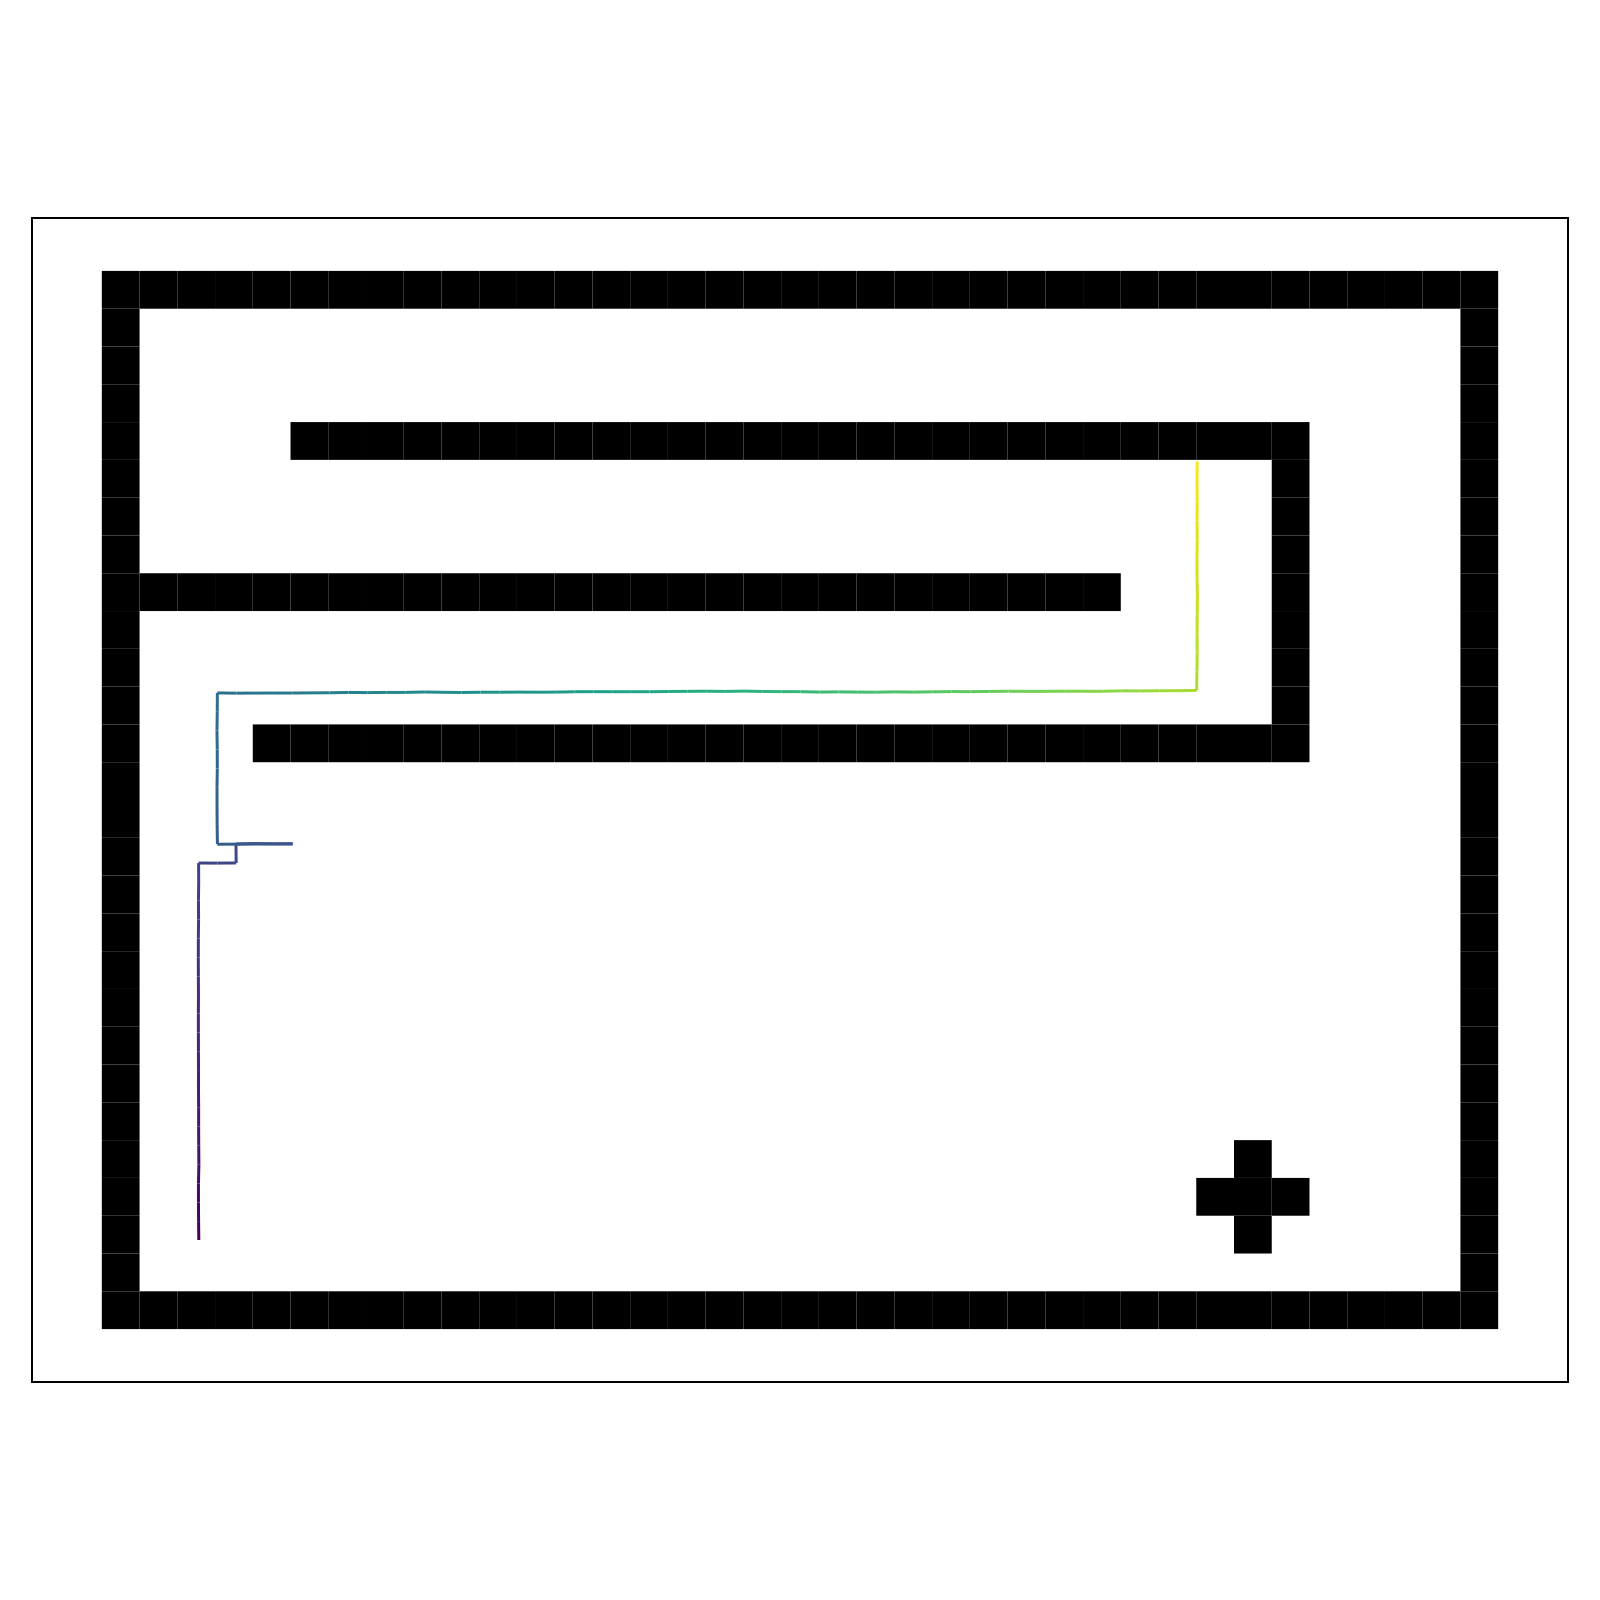

CairoMakie.Screen{IMAGE}


In [443]:
# Plot path we got rid of 
tr = named_trace_lists["learnmap"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.plot_paths(
    params.map,
    [[[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for (i, tr) in old_traces_test1 if !trace_hit_barrier(tr) && !trace_reached_cross(tr)][1]]
)
display(f)

In [444]:
Dict(k => length(v) for (k, v) in pairs(named_trace_lists))

Dict{String, Int64} with 5 entries:
  "learnmap"     => 16
  "learnstrange" => 17
  "intro"        => 28
  "test2"        => 18
  "test1"        => 19

In [445]:
[i for (i, _) in named_trace_lists["test1"]]

19-element Vector{Int64}:
  1
  2
  2
  3
  3
  4
  4
  5
  6
  6
  7
  8
  9
  9
 10
 11
 12
 13
 13

In [446]:
participant_names[11]

"isha"

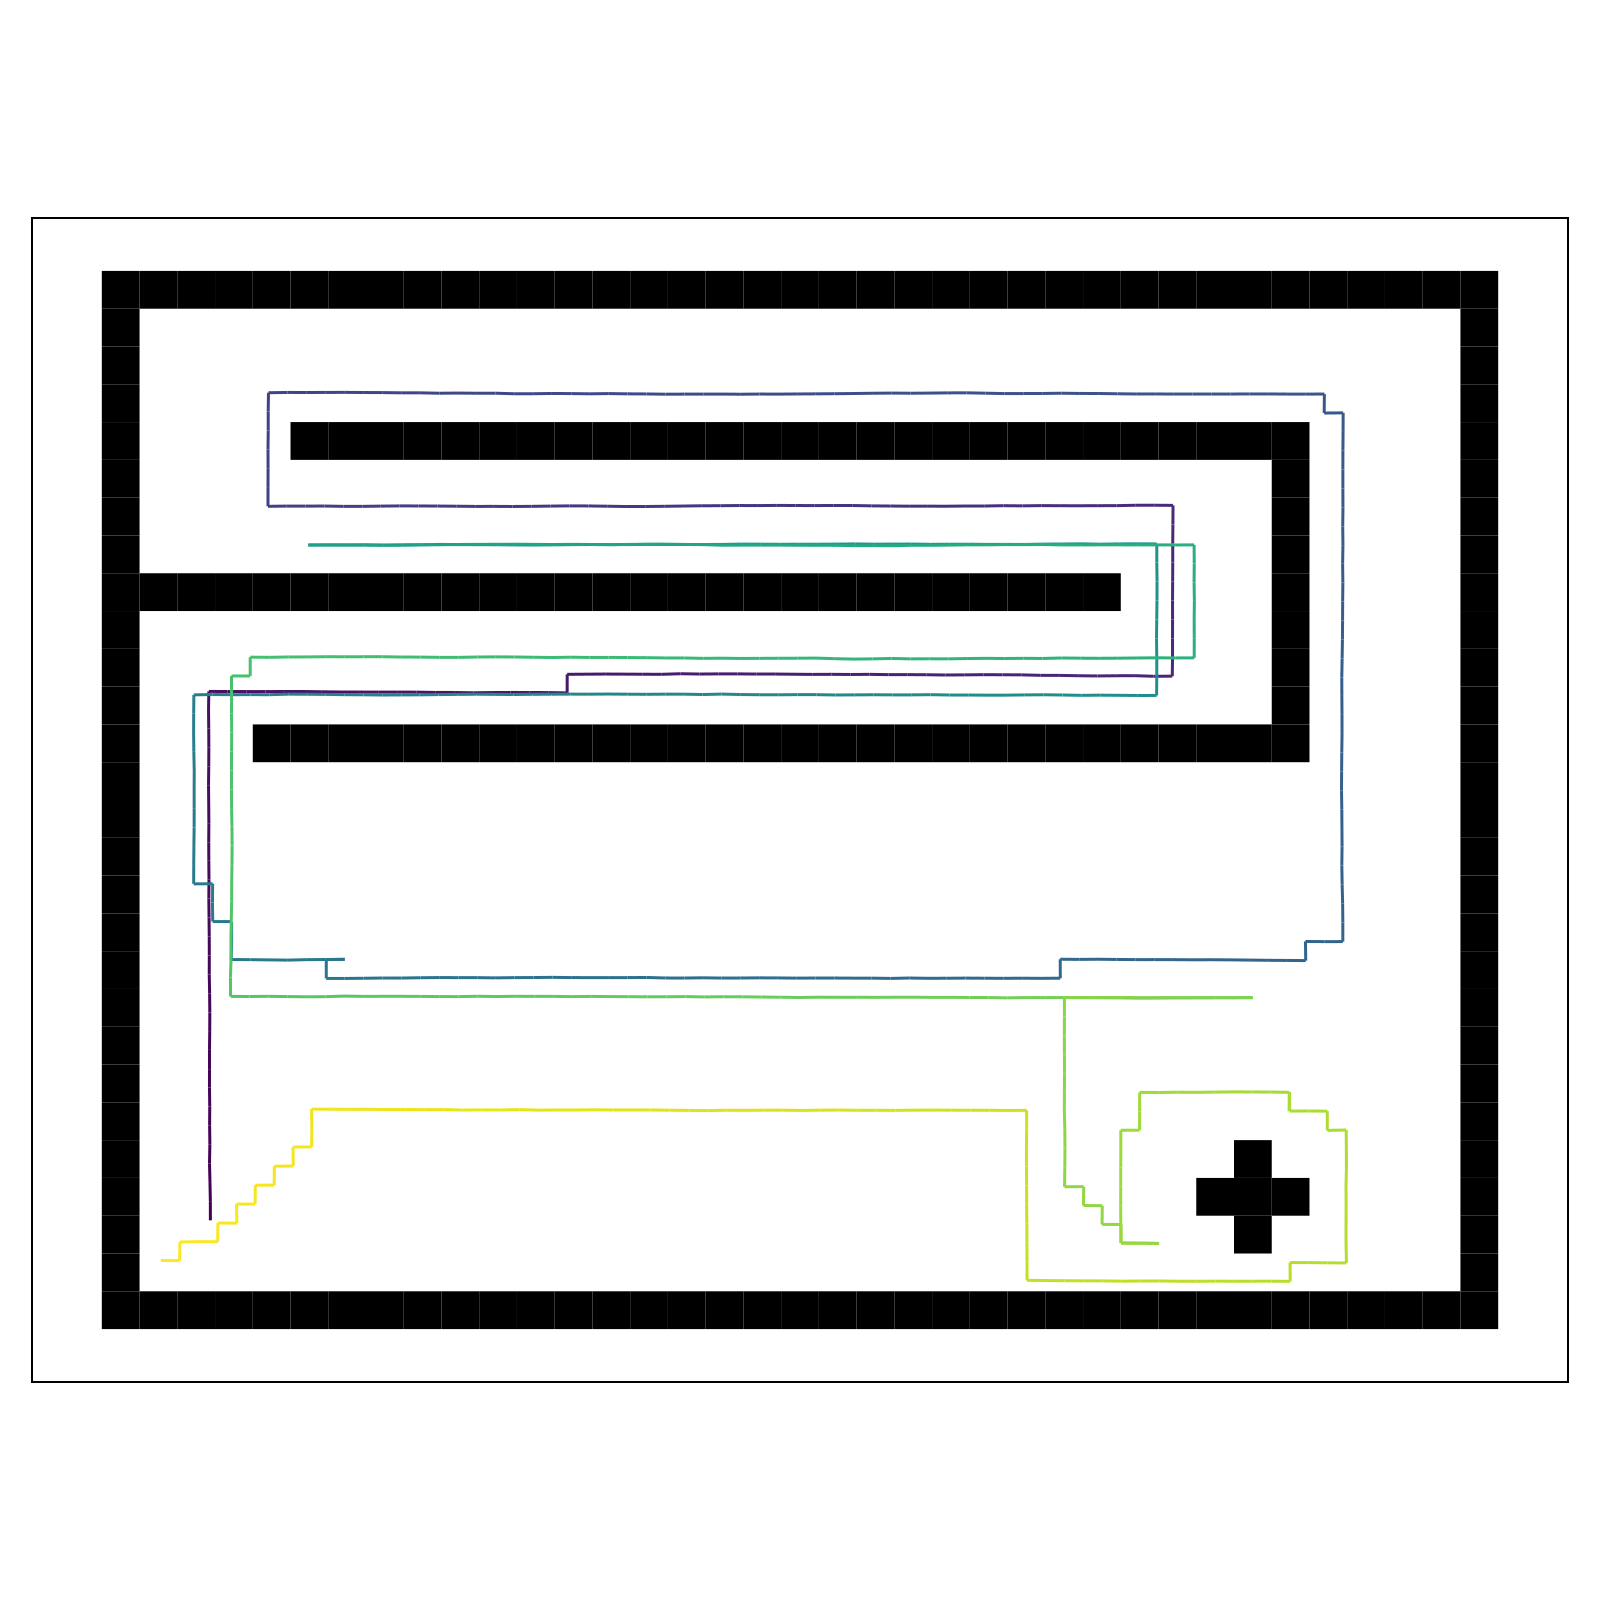

CairoMakie.Screen{IMAGE}


In [447]:
# Plot 1 path
i = 4
tr = named_trace_lists["learnmap"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.plot_paths(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)]]
)
display(f)

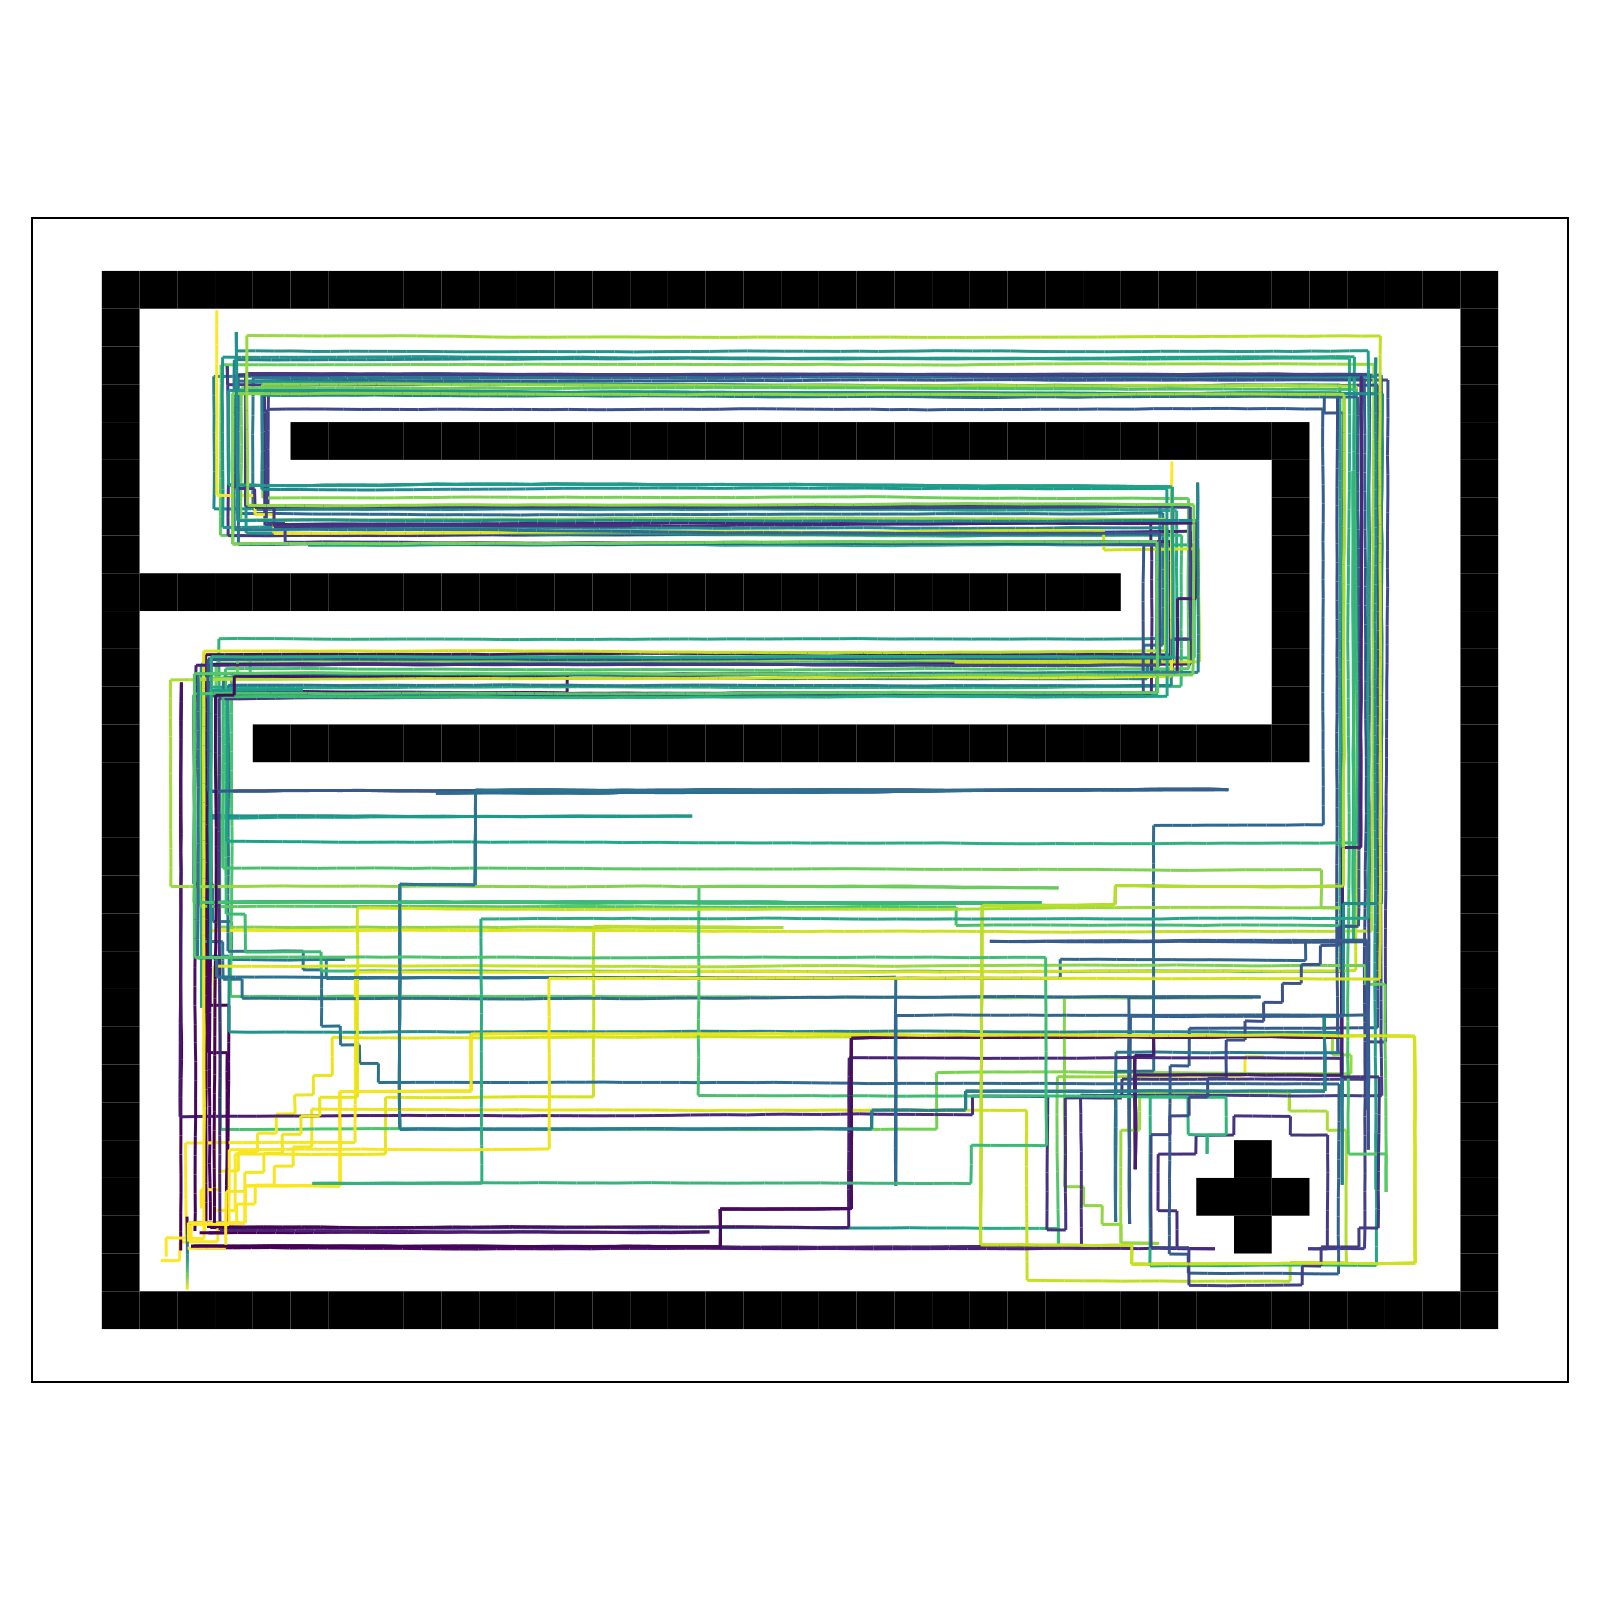

CairoMakie.Screen{IMAGE}


In [448]:
# Plot 2 paths
i = 4
tr = named_trace_lists["learnmap"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.plot_paths(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(named_trace_lists["learnmap"][i][2])] for i in 1:length(named_trace_lists["learnmap"])]
)
display(f)

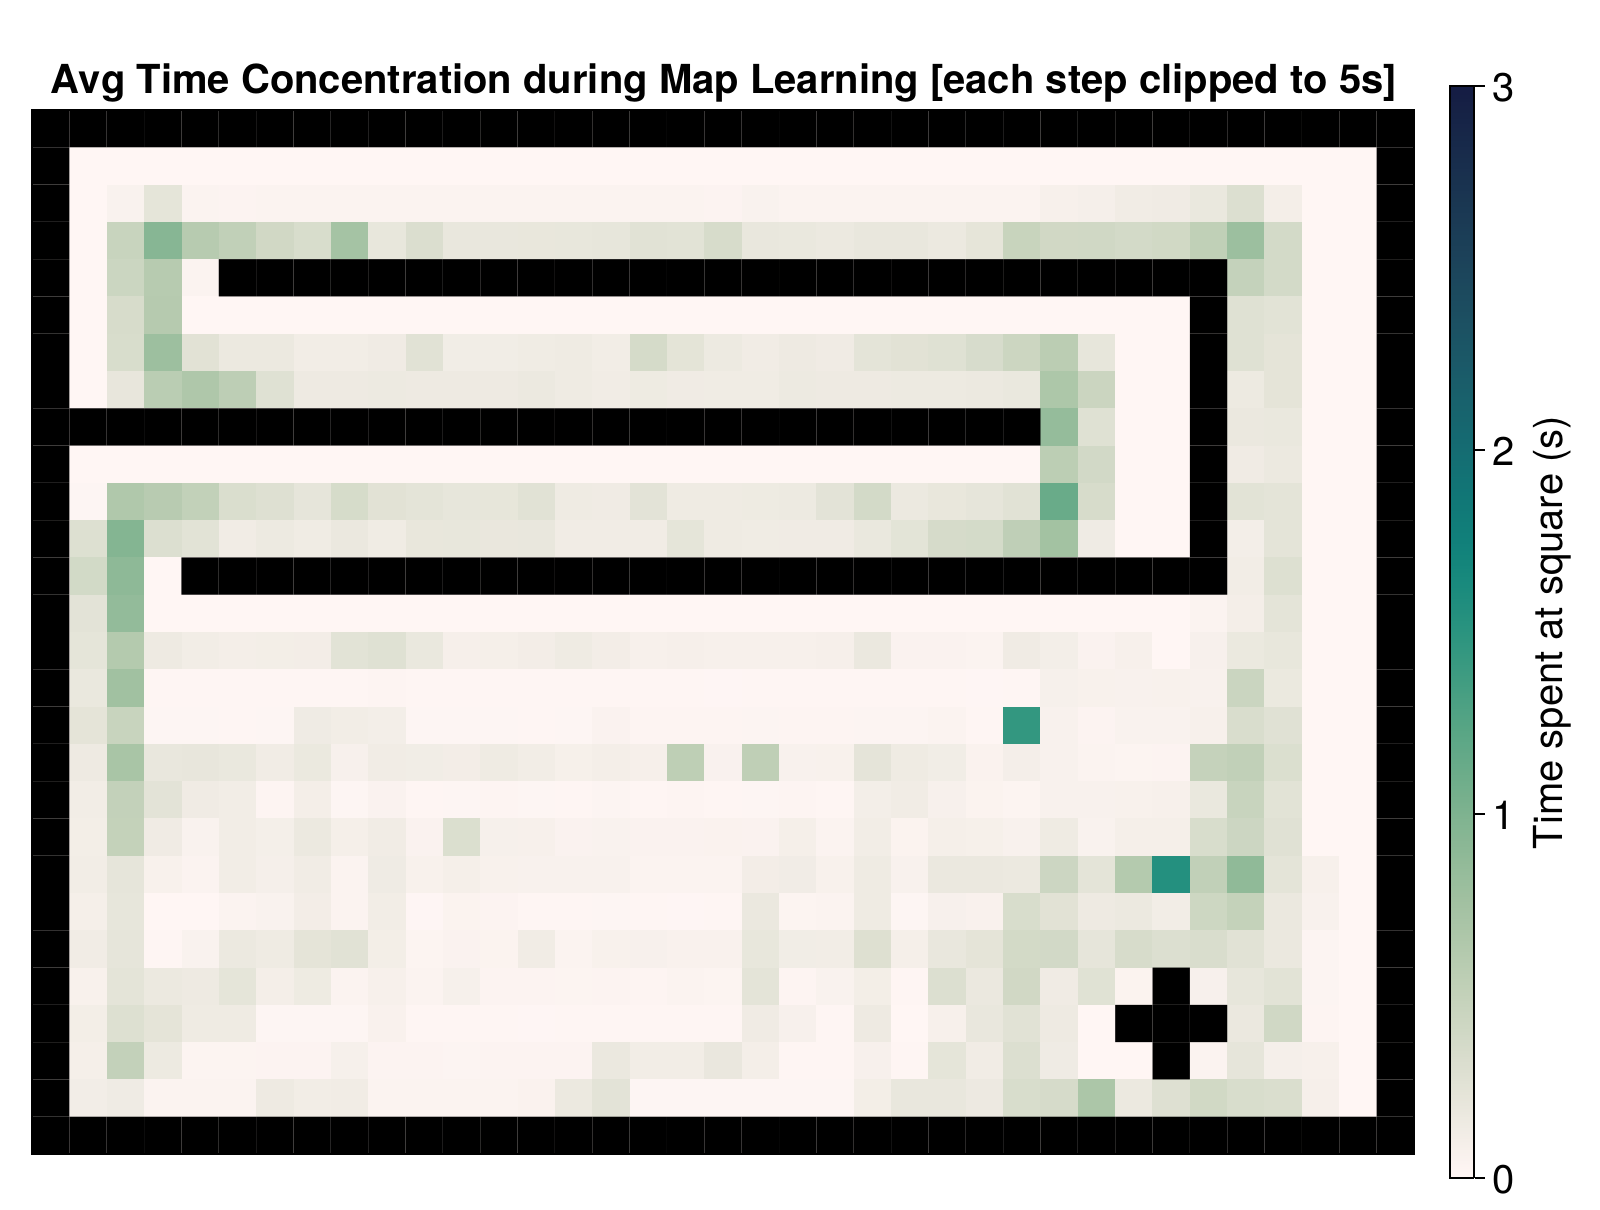

In [449]:
# multi-run heatmap
f = GridWorlds.Viz.time_heatmap(
    get_args(named_trace_lists["learnmap"][1][2])[3](0).map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["learnmap"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["learnmap"])],
    title="Avg Time Concentration during Map Learning [each step clipped to 5s]",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["learnmap"])))
)
Makie.save("030_learnmap_times.pdf", f)
f

^ maybe not surprising, people spend time checking out the cross, and the hallway

Now try in the first test:

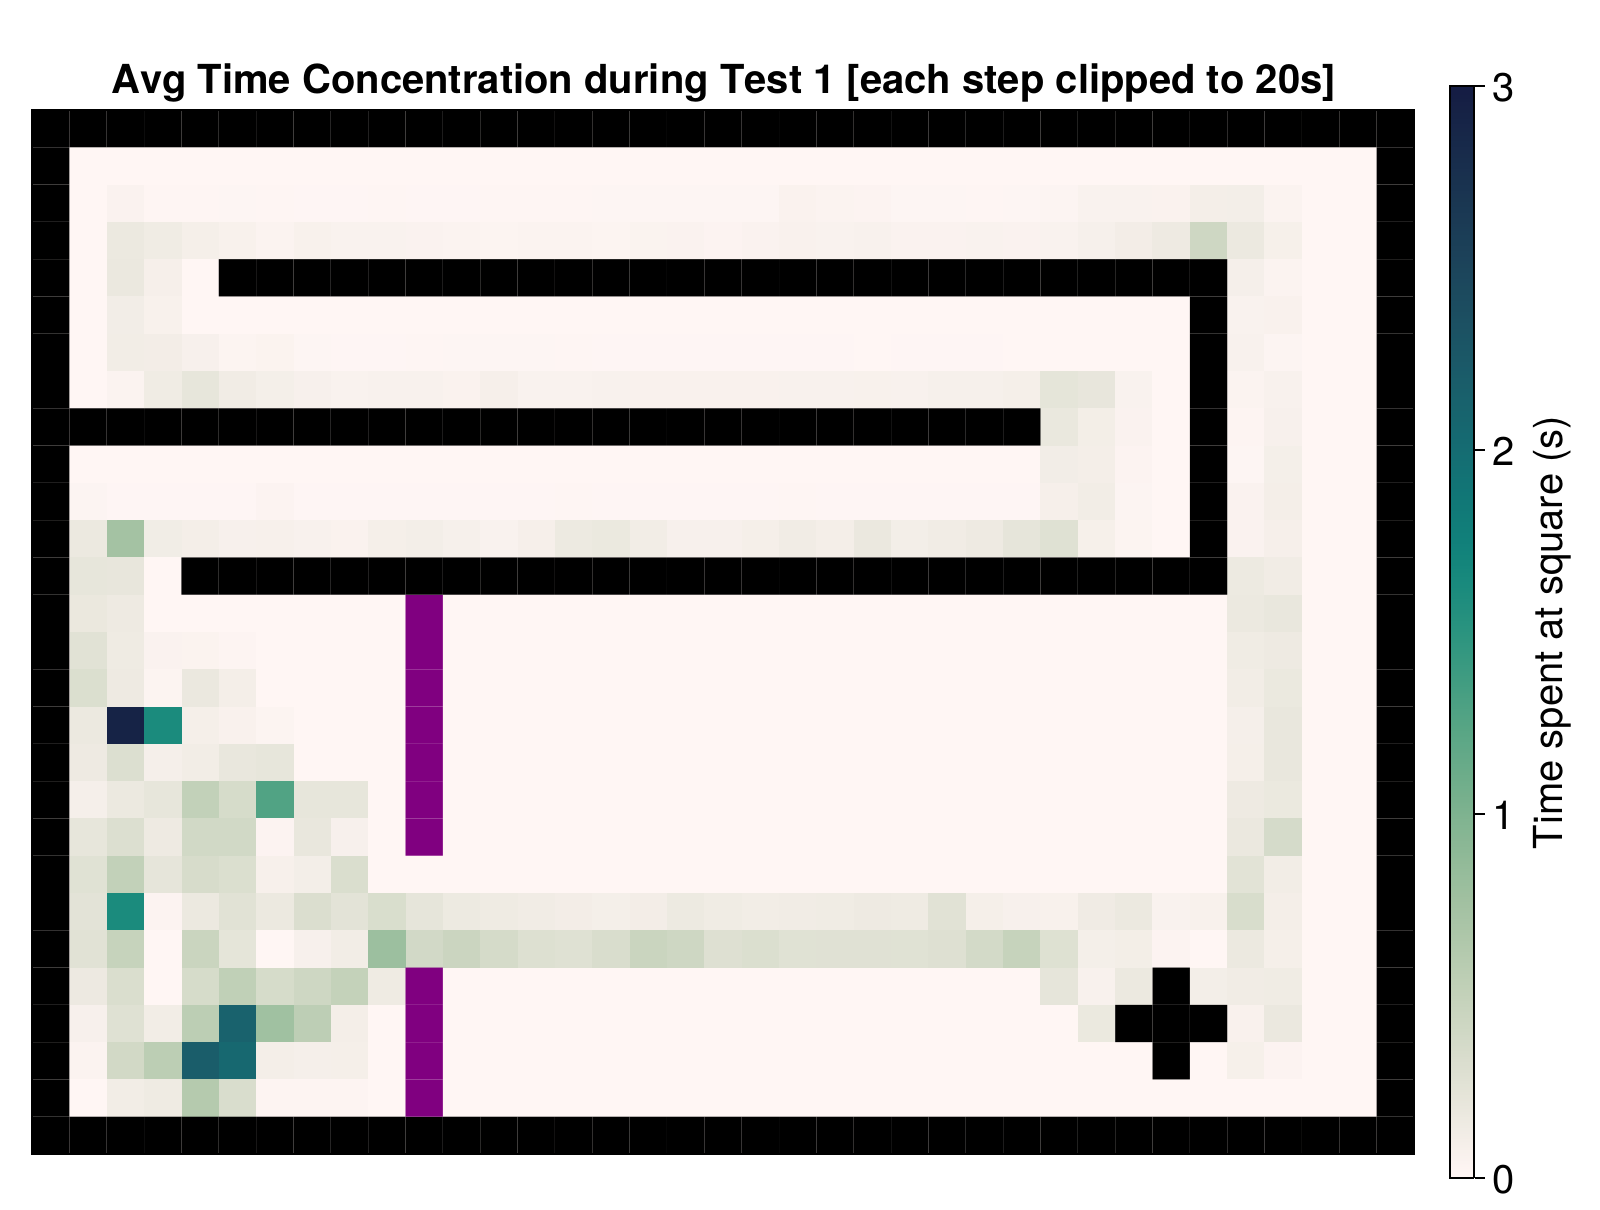

In [450]:
# multi-run heatmap

i = 4
tr = named_trace_lists["test1"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    clip_ms=20_000,
    title="Avg Time Concentration during Test 1 [each step clipped to 20s]",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test1"])))
)

Makie.save("032_test1_times.pdf", f)
f

^ times spent

v steps spent

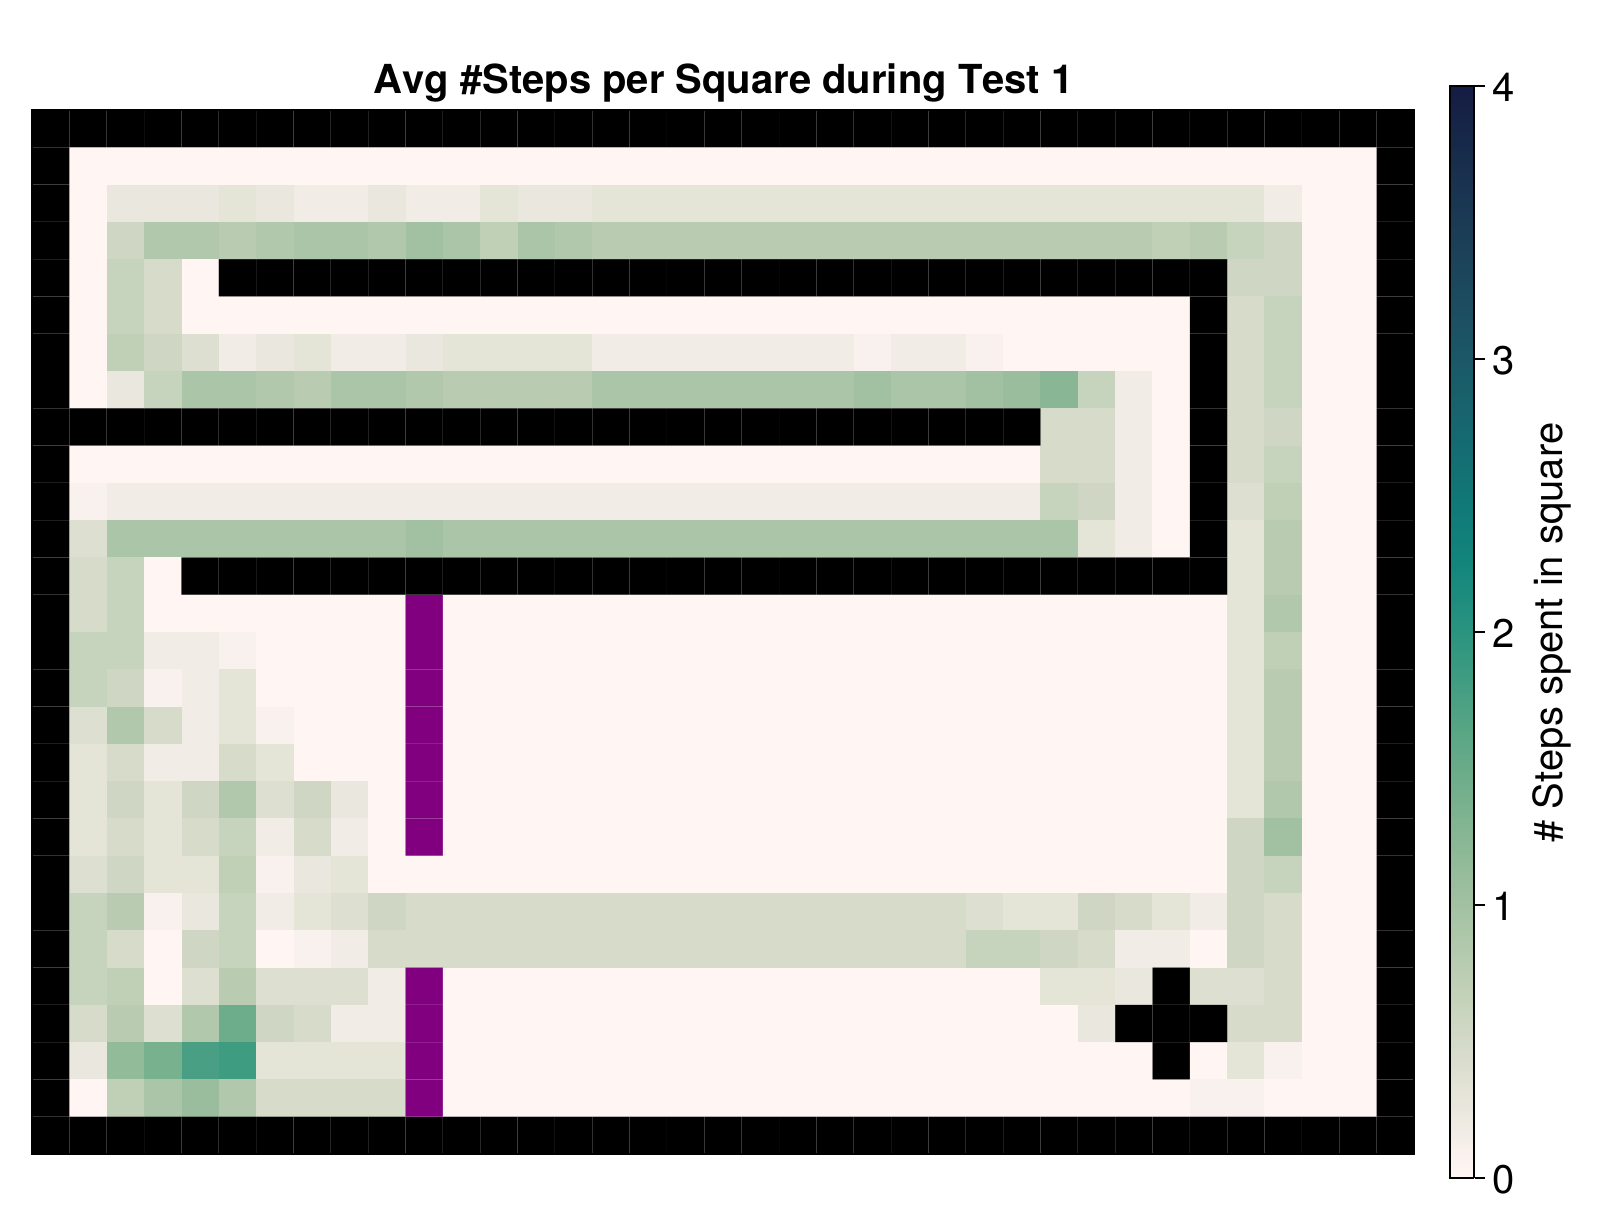

In [451]:
f = GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    use_times=false,
    title="Avg #Steps per Square during Test 1",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test1"])))
)


Makie.save("034_test1_steps.pdf", f)
f

now, look at final run times

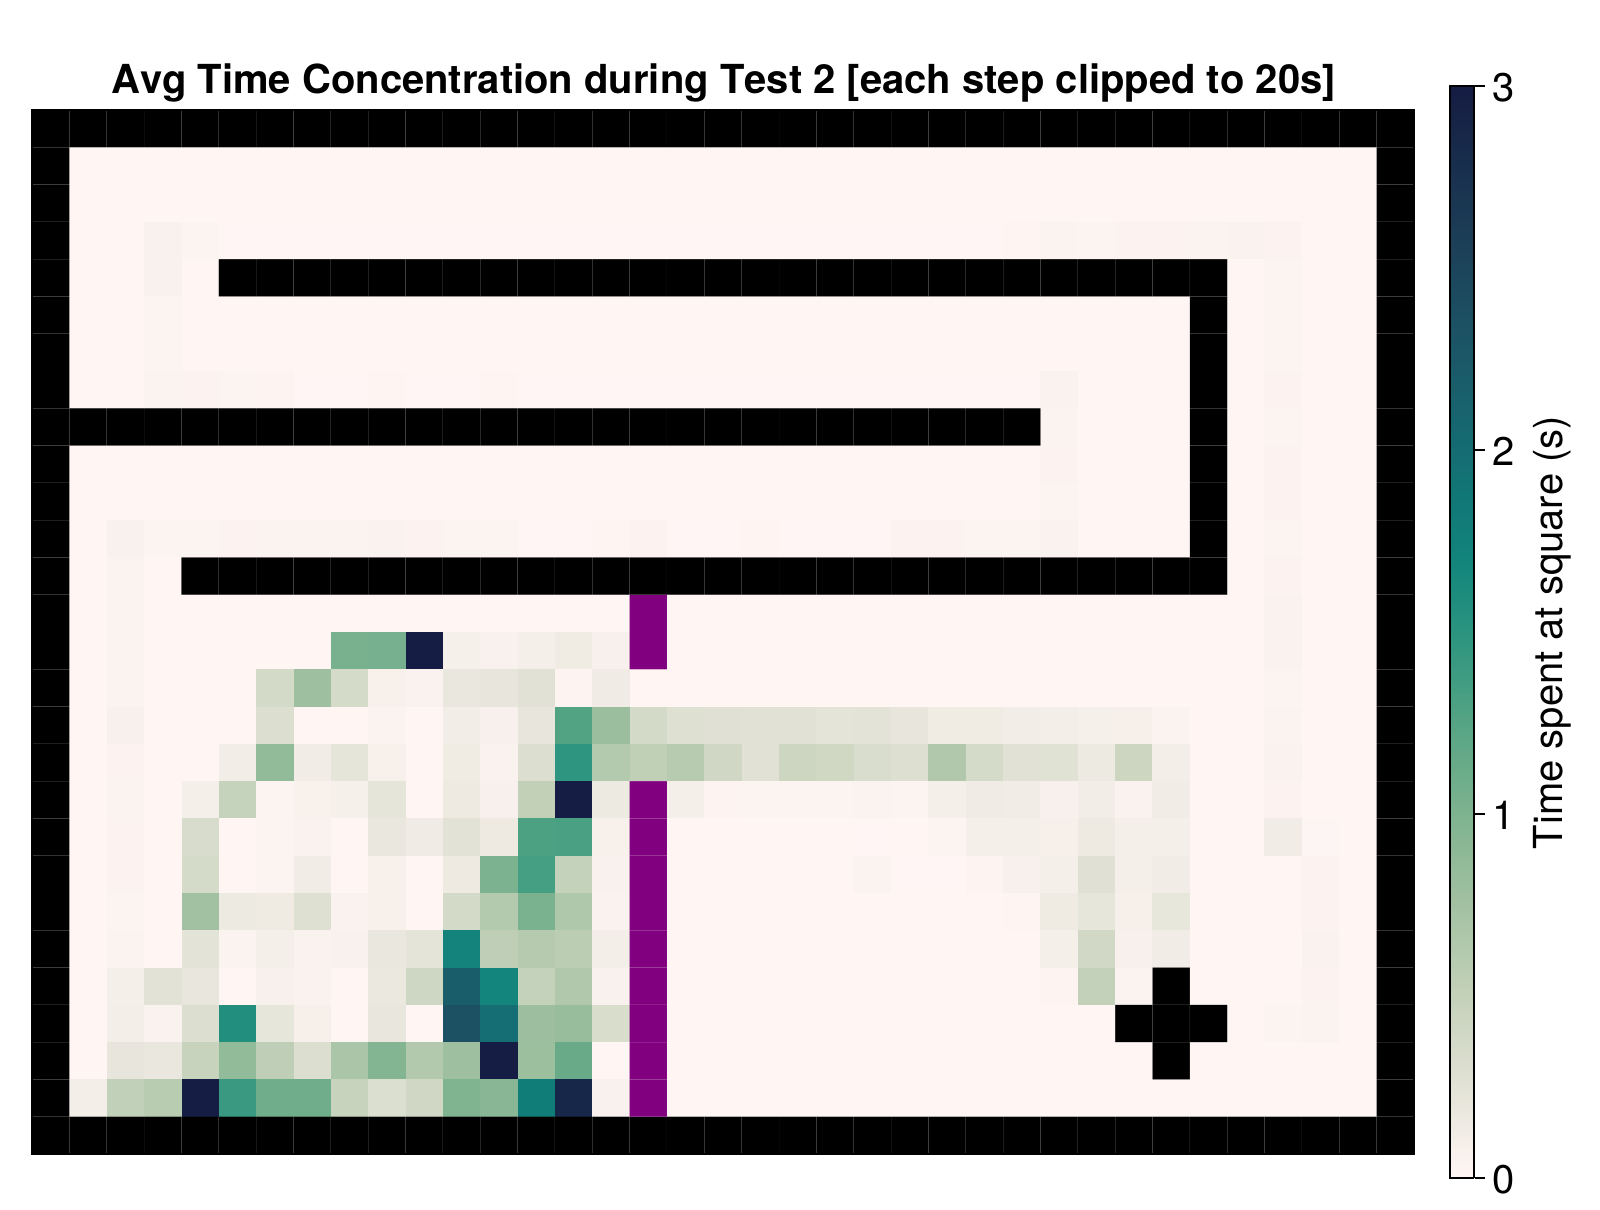

In [452]:
# multi-run heatmap

i = 4
tr = named_trace_lists["test2"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    clip_ms=20_000,
    title="Avg Time Concentration during Test 2 [each step clipped to 20s]",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test2"])))
)


Makie.save("042_test2_times.pdf", f)
f

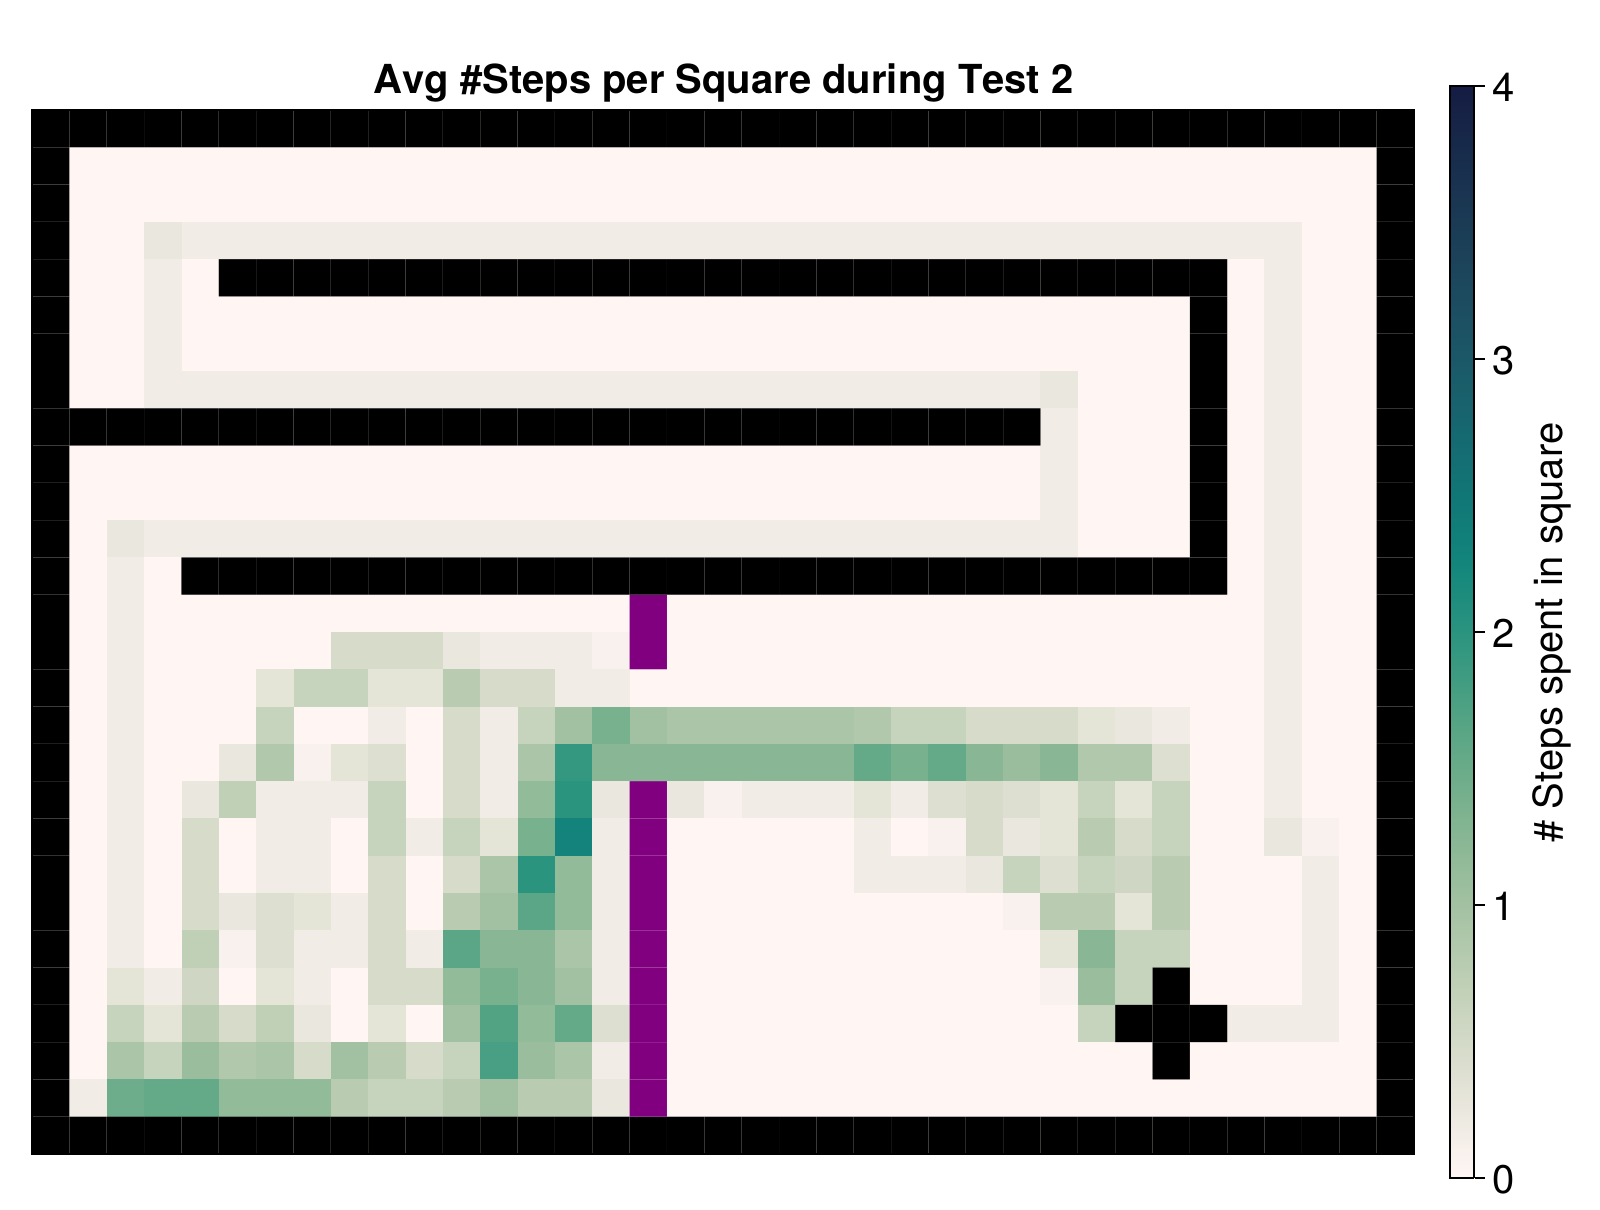

In [453]:
f = GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    use_times=false,
    title="Avg #Steps per Square during Test 2",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test2"])))
)

Makie.save("044_test2_steps.pdf", f)
f

## Fraction hitting wall

named_trace_lists

In [345]:
keys(named_trace_lists)

KeySet for a Dict{String, Vector{Any}} with 5 entries. Keys:
  "learnmap"
  "learnstrange"
  "intro"
  "test2"
  "test1"

In [346]:
probable_collisions_indices = [i for (i, tr) in named_trace_lists["test1"] if trace_hit_barrier(tr)]

6-element Vector{Int64}:
  2
  3
  4
  6
  9
 13

In [347]:
[(i, get_args(tr)[1]) for (i, tr) in named_trace_lists["test1"] if i in probable_collisions_indices]

12-element Vector{Tuple{Int64, Int64}}:
 (2, 15)
 (2, 85)
 (3, 77)
 (3, 258)
 (4, 15)
 (4, 261)
 (6, 15)
 (6, 264)
 (9, 16)
 (9, 268)
 (13, 15)
 (13, 309)

### traces that took the long route:

In [348]:
[i for (i, tr) in named_trace_lists["test1"] if get_args(tr)[1] > 100]

7-element Vector{Int64}:
  1
  3
  4
  6
  9
 11
 13

### slowdown amount:

In [353]:
function time_in_range(tr, bot, top)
    as = GenPOMDPs.action_sequence(tr)
    if length(as) < bot
        return 0
    elseif length(as) < top
        return (as[end][2] - as[bot][2]).value
    else
        return (as[top][2] - as[bot][2]).value
    end
end
time_on_5to8(tr) = time_in_range(tr, 5, 8)

time_on_5to8 (generic function with 1 method)

In [354]:
__times = [
    (i, trace_hit_barrier(tr), time_in_range(tr, 5, 10)/5, time_in_range(tr, 1, 4)/3) for (i, tr) in named_trace_lists["test1"] if !trace_hit_barrier(tr)
]

# sum([t1 > 2*t2 ? 1 : 0 for (_, _, t1, t2) in __times ])

13-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 1659.8, 215.0)
 (2, 0, 678.0, 275.6666666666667)
 (3, 0, 35.6, 107.33333333333333)
 (4, 0, 692.4, 263.3333333333333)
 (5, 0, 1570.2, 889.3333333333334)
 (6, 0, 251.8, 335.6666666666667)
 (7, 0, 4052.4, 1499.6666666666667)
 (8, 0, 2862.2, 478.6666666666667)
 (9, 0, 150.8, 215.33333333333334)
 (10, 0, 712.0, 251.66666666666666)
 (11, 0, 309.6, 215.0)
 (12, 0, 690.6, 287.6666666666667)
 (13, 0, 1147.8, 348.0)

In [355]:
[i for (i, _, t1, t2) in __times if t1 > 2*t2]

8-element Vector{Int64}:
  1
  2
  4
  7
  8
 10
 12
 13

how many of those that didn't slow by much had already experienced a collision?:

In [360]:
[any(
    trace_hit_barrier(tr_) for (i_, tr_) in named_trace_lists["test1"] if i_ == i
) for (i, _, t1, t2) in __times if t1 < 1.5 * t2]

4-element Vector{Bool}:
 1
 1
 1
 0

In [361]:
# # i = 4
# # tr = named_trace_lists["test1"][i][2]
# # t, _, t_to_params = get_args(tr)
# # params = t_to_params(t)

# trace = named_trace_lists["test1"][]

# f = GridWorlds.Viz.time_heatmap(
#     params.map,
#     [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
#     [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
#     use_times=false,
#     title="Avg #Steps per Square during Test 1",
#     do_avg=true,
#     n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test12]))),
#     showticks=true
# )

# f

In [362]:
# [(i, trace_reached_cross(tr)) for (i, tr) in named_trace_lists["test1"] ]

# [(i, get_args(tr)[1]) for (i, tr) in named_trace_lists["test1"] if !trace_reached_cross(tr)]

In [363]:
# (i, tr) = named_trace_lists["test1"][1];
# GenPOMDPs.state_sequence(tr)

In [364]:
# [(i, get_args(tr)[1]) for (i, tr) in named_trace_lists["test1"] if get_args(tr)[1] == 77]

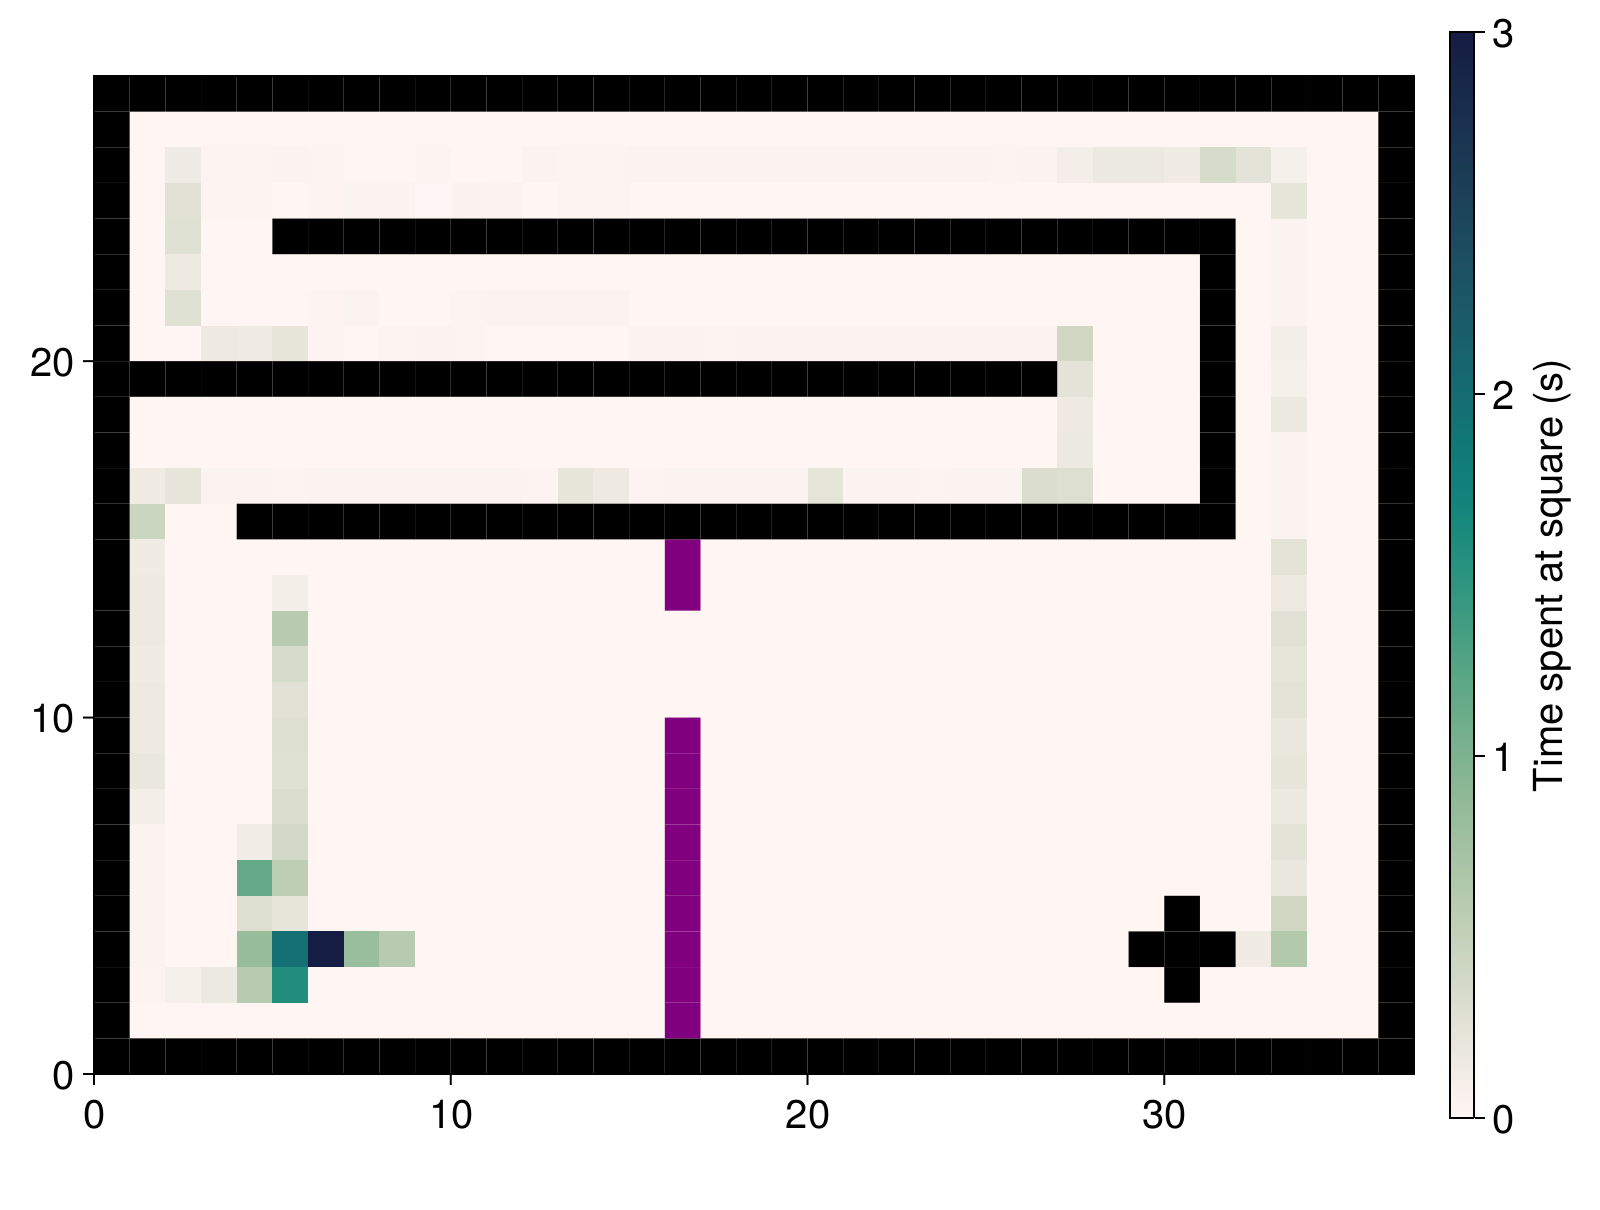

In [386]:
f = GridWorlds.Viz.time_heatmap(
    get_args(named_trace_lists["test2"][1][2])[3](30).map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], [(i, tr) for (i, tr) in named_trace_lists["test1"] if i == 3])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], [(i, tr) for (i, tr) in named_trace_lists["test1"] if i == 3])],
    use_times=true,
    # title="Avg #Steps per Square during Test 1",
    # do_avg=true,
    # n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test2"]))),
    showticks=true
)

f

## Time behind barrier

In [366]:

function time_behind_barrier_map1(tr)
    maxt = 0
    for (p, t, h) in GenPOMDPs.state_sequence(tr)
        if behind_wall_map1(p[1], p[2])
            maxt = max(maxt, t)
        end
    end
    return time_in_range(tr, 1, maxt)
end

function time_behind_barrier_map2(tr)
    maxt = 0
    for (p, t, h) in GenPOMDPs.state_sequence(tr)
        if behind_wall_map2(p[1], p[2])
            maxt = max(maxt, t)
        end
    end
    return time_in_range(tr, 1, maxt)
end

time_behind_barrier_map2 (generic function with 1 method)

In [372]:
times_test1 = [
    (i, time_behind_barrier_map1(tr)) for (i, tr) in named_trace_lists["test1"] if !trace_hit_barrier(tr)
]
# i_to_times1 = Dict(times_test1)

13-element Vector{Tuple{Int64, Int64}}:
 (1, 104468)
 (2, 13040)
 (3, 2623)
 (4, 27159)
 (5, 21666)
 (6, 11440)
 (7, 58617)
 (8, 35310)
 (9, 13459)
 (10, 27178)
 (11, 5103)
 (12, 23011)
 (13, 64965)

In [373]:
times_test2 = [
    (i, time_behind_barrier_map2(tr)) for (i, tr) in named_trace_lists["test2"] if !trace_hit_barrier(tr)
]
i_to_times2 = Dict(i => maximum([t for (j, t) in times_test2 if j == i]) for (i, time) in times_test2)

Dict{Int64, Int64} with 13 entries:
  5  => 40208
  12 => 159483
  8  => 31107
  1  => 98827
  6  => 40208
  11 => 5439
  9  => 57338
  3  => 62374
  7  => 159483
  4  => 30439
  13 => 159483
  2  => 24448
  10 => 21456

In [400]:
ratios = Dict(i => (i_to_times2[i])/i_to_times1[i] for i in keys(i_to_times1))

Dict{Int64, Float64} with 13 entries:
  5  => 1.85581
  12 => 6.93073
  8  => 0.880969
  1  => 0.946003
  6  => 3.51469
  11 => 1.06584
  9  => 4.2602
  3  => 23.7796
  7  => 2.72076
  4  => 1.12077
  13 => 2.45491
  2  => 1.87485
  10 => 0.789462

In [378]:
length([v for v in values(ratios) if v > 1])

10

In [387]:
average(v)= sum(v)/length(v)
average(collect(v for v in values(ratios)))

4.014971397024334

In [401]:
average(v)= sum(v)/length(v)
average(collect(v for v in values(ratios) if v < 10))

2.367915544133079

In [395]:
function pos_in_a_top_hallway(x, y)
    return y > 20

end
function trace_took_long_route(trace)
    return any(pos_in_a_top_hallway(p[1], p[2]) for (p, t, h) in GenPOMDPs.state_sequence(trace))
end
function participant_took_short_route(j)
    traces = [tr for (i, tr) in named_trace_lists["test1"] if i == j]
    trace = traces[end]
    return !trace_took_long_route(trace)
end

participant_took_short_route (generic function with 1 method)

In [402]:
average(collect(v for (k, v) in ratios if participant_took_short_route(k)))

2.508763430956276

In [412]:
avg_short= average([v for (i, v) in i_to_times2 if participant_took_short_route(i)])

72697.5

In [413]:
avg_long = average([v for (i, v) in i_to_times2 if !participant_took_short_route(i)])

64872.57142857143

In [414]:
avg_short - avg_long

7824.9285714285725

## action vs time

In [438]:
function action_to_time_while_behind_barrier_map1(tr)
    a_to_t = Dict(:up => 0, :down => 0, :left => 0, :right => 0, :stay => 0)
    a_to_n = Dict(:up => 0, :down => 0, :left => 0, :right => 0, :stay => 0)
    actions = GenPOMDPs.action_sequence(tr)
    states = GenPOMDPs.state_sequence(tr)
    for ((p, t, h), (a, time), (aprev, timeprev)) in zip(states[3:end], actions[2:end], actions[1:end-1])
        if behind_wall_map1(p[1], p[2])
            a_to_t[aprev] += (time - timeprev).value
            a_to_n[aprev] += 1
        end
    end
    return (a_to_t, a_to_n)
end
function action_to_avg_time_behind_barrier_map1(tr)
    (a_to_t, a_to_n) = action_to_time_while_behind_barrier_map1(tr)
    return Dict(a => a_to_t[a]/a_to_n[a] for a in keys(a_to_t))
end

function action_to_time_while_behind_barrier_map2(tr)
    a_to_t = Dict(:up => 0, :down => 0, :left => 0, :right => 0, :stay => 0)
    a_to_n = Dict(:up => 0, :down => 0, :left => 0, :right => 0, :stay => 0)
    actions = GenPOMDPs.action_sequence(tr)
    states = GenPOMDPs.state_sequence(tr)
    for ((p, t, h), (a, time), (aprev, timeprev)) in zip(states[3:end], actions[2:end], actions[1:end-1])
        if behind_wall_map2(p[1], p[2])
            a_to_t[aprev] += (time - timeprev).value
            a_to_n[aprev] += 1
        end
    end
    return (a_to_t, a_to_n)
end
function action_to_avg_time_behind_barrier_map2(tr)
    (a_to_t, a_to_n) = action_to_time_while_behind_barrier_map2(tr)
    return Dict(a => a_to_t[a]/a_to_n[a] for a in keys(a_to_t))
end

action_to_avg_time_behind_barrier_map2 (generic function with 1 method)

In [439]:
[action_to_avg_time_behind_barrier_map1(tr) for (i, tr) in named_trace_lists["test1"] if !trace_hit_barrier(tr)]

13-element Vector{Dict{Symbol, Float64}}:
 Dict(:left => 5679.4, :right => 8015.5, :stay => NaN, :up => 1760.36, :down => NaN)
 Dict(:left => 466.0, :right => 407.29411764705884, :stay => NaN, :up => 273.46666666666664, :down => 221.14285714285714)
 Dict(:left => NaN, :right => NaN, :stay => NaN, :up => 104.92, :down => NaN)
 Dict(:left => 259.4, :right => 395.8333333333333, :stay => NaN, :up => 903.3461538461538, :down => NaN)
 Dict(:left => NaN, :right => 968.2666666666667, :stay => NaN, :up => 1190.3333333333333, :down => NaN)
 Dict(:left => 308.14285714285717, :right => 303.2857142857143, :stay => NaN, :up => 286.4, :down => NaN)
 Dict(:left => NaN, :right => 2453.125, :stay => NaN, :up => 3227.8333333333335, :down => NaN)
 Dict(:left => NaN, :right => 1034.7333333333333, :stay => NaN, :up => 1870.375, :down => 2413.0)
 Dict(:left => NaN, :right => NaN, :stay => NaN, :up => 441.25925925925924, :down => 772.5)
 Dict(:left => 540.0, :right => 811.0588235294117, :stay => NaN, :up => 8

In [440]:
action_to_time_count = [action_to_time_while_behind_barrier_map2(tr) for (i, tr) in named_trace_lists["test2"] if !trace_hit_barrier(tr)]

a_to_t = Dict(:up => 0, :down => 0, :left => 0, :right => 0, :stay => 0)
a_to_n = Dict(:up => 0, :down => 0, :left => 0, :right => 0, :stay => 0)

for (a_to_t_, a_to_n_) in action_to_time_count
    for a in keys(a_to_t_)
        a_to_t[a] += a_to_t_[a]
        a_to_n[a] += a_to_n_[a]
    end
end

Dict(a => a_to_t[a]/a_to_n[a] for a in keys(a_to_t))

Dict{Symbol, Float64} with 5 entries:
  :left  => 1073.18
  :right => 1148.27
  :stay  => NaN
  :up    => 853.076
  :down  => 491.398

In [441]:
a_to_t

Dict{Symbol, Int64} with 5 entries:
  :left  => 23610
  :right => 499498
  :stay  => 0
  :up    => 418007
  :down  => 98771

In [442]:
a_to_n

Dict{Symbol, Int64} with 5 entries:
  :left  => 22
  :right => 435
  :stay  => 0
  :up    => 490
  :down  => 201

In [457]:
function total_time(trace)
    actions = GenPOMDPs.action_sequence(trace)
    states = GenPOMDPs.state_sequence(trace)
    return (actions[end][2] - actions[1][2]).value
end
function total_n_steps(trace)
    actions = GenPOMDPs.action_sequence(trace)
    return length(actions)
end
function avg_step_time(traces)
    return sum([total_time(tr) for tr in traces])/sum([total_n_steps(tr) for tr in traces])
end
avg_step_time([tr for (_, tr) in named_trace_lists["learnmap"]])

108.77929846823167

In [460]:
avg_step_time([tr for (_, tr) in named_trace_lists["test2"]])

634.6849514563107

In [461]:
avg_step_time([tr for (_, tr) in named_trace_lists["test1"]])

319.68442456283043